# Solar Power Generation


## Preparation


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim


for dirname, _, filenames in os.walk("./data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Plant_2_Generation_Data.csv
./data/Plant_1_Generation_Data.csv
./data/Plant_2_Weather_Sensor_Data.csv
./data/Plant_1_Weather_Sensor_Data.csv


In [21]:
# Data Loading
generation_data_plant_1 = pd.read_csv("./data/Plant_1_Generation_Data.csv")
weather_data_plant_1 = pd.read_csv("./data/Plant_1_Weather_Sensor_Data.csv")
generation_data_plant_2 = pd.read_csv("./data/Plant_2_Generation_Data.csv")
weather_data_plant_2 = pd.read_csv("./data/Plant_2_Weather_Sensor_Data.csv")

In [22]:
generation_data_plant_1_head = generation_data_plant_1.head()
weather_data_plant_1_head = weather_data_plant_1.head()
generation_data_plant_2_head = generation_data_plant_2.head()
weather_data_plant_2_head = weather_data_plant_2.head()

generation_data_plant_1_head, weather_data_plant_1_head
generation_data_plant_2_head, weather_data_plant_2_head

(             DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
 0  2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
 1  2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
 2  2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
 3  2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
 4  2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
 
    DAILY_YIELD   TOTAL_YIELD  
 0  9425.000000  2.429011e+06  
 1     0.000000  1.215279e+09  
 2  3075.333333  2.247720e+09  
 3   269.933333  1.704250e+06  
 4  3177.000000  1.994153e+07  ,
              DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
 0  2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
 1  2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
 2  2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
 3  2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0           

## Data Exploration


### Data Cleaning


In [23]:
generation_data_plant_1_missing_values = generation_data_plant_1.isnull().sum()
weather_data_plant_1_missing_values = weather_data_plant_1.isnull().sum()
generation_data_plant_2_missing_values = generation_data_plant_2.isnull().sum()
weather_data_plant_2_missing_values = weather_data_plant_2.isnull().sum()

print(generation_data_plant_1_missing_values)
print(weather_data_plant_1_missing_values)
print(generation_data_plant_2_missing_values)
print(weather_data_plant_2_missing_values)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64
DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64
DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [24]:
# Convert DATE_TIME columns to datetime
generation_data_plant_1["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_1["DATE_TIME"], format="%d-%m-%Y %H:%M"
)
weather_data_plant_1["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_1["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
generation_data_plant_2["DATE_TIME"] = pd.to_datetime(
    generation_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)
weather_data_plant_2["DATE_TIME"] = pd.to_datetime(
    weather_data_plant_2["DATE_TIME"], format="%Y-%m-%d %H:%M:%S"
)

#### Plant 1


In [25]:
generation_data_plant_1.drop(["PLANT_ID"], axis=1, inplace=True)
weather_data_plant_1.drop(["PLANT_ID", "SOURCE_KEY"], axis=1, inplace=True)

generation_data_plant_1.head(), weather_data_plant_1.tail()

(   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD
 0 2020-05-15  1BY6WEcLGh8j5v7       0.0       0.0          0.0    6259559.0
 1 2020-05-15  1IF53ai7Xc0U56Y       0.0       0.0          0.0    6183645.0
 2 2020-05-15  3PZuoBAID5Wc2HD       0.0       0.0          0.0    6987759.0
 3 2020-05-15  7JYdWkrLSPkdwr4       0.0       0.0          0.0    7602960.0
 4 2020-05-15  McdE0feGgRqW7Ca       0.0       0.0          0.0    7158964.0,
                DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
 3177 2020-06-17 22:45:00            22.150570           21.480377          0.0
 3178 2020-06-17 23:00:00            22.129816           21.389024          0.0
 3179 2020-06-17 23:15:00            22.008275           20.709211          0.0
 3180 2020-06-17 23:30:00            21.969495           20.734963          0.0
 3181 2020-06-17 23:45:00            21.909288           20.427972          0.0)

In [26]:
plant_1_data = generation_data_plant_1.merge(weather_data_plant_1, on="DATE_TIME")
plant_1_data.dropna(inplace=True)

plant_1_data.tail()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
68769,2020-06-17 23:45:00,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,21.909288,20.427972,0.0
68770,2020-06-17 23:45:00,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,21.909288,20.427972,0.0
68771,2020-06-17 23:45:00,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,21.909288,20.427972,0.0
68772,2020-06-17 23:45:00,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,21.909288,20.427972,0.0
68773,2020-06-17 23:45:00,zVJPv84UY57bAof,0.0,0.0,5910.000,7363272.0,21.909288,20.427972,0.0


#### Plant 2


In [27]:
generation_data_plant_2.drop(["PLANT_ID"], axis=1, inplace=True)
weather_data_plant_2.drop(["PLANT_ID", "SOURCE_KEY"], axis=1, inplace=True)

generation_data_plant_2.head(), weather_data_plant_2.tail()

(   DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD
 0 2020-05-15  4UPUqMRk7TRMgml       0.0       0.0  9425.000000  2.429011e+06
 1 2020-05-15  81aHJ1q11NBPMrL       0.0       0.0     0.000000  1.215279e+09
 2 2020-05-15  9kRcWv60rDACzjR       0.0       0.0  3075.333333  2.247720e+09
 3 2020-05-15  Et9kgGMDl729KT4       0.0       0.0   269.933333  1.704250e+06
 4 2020-05-15  IQ2d7wF4YD8zU1Q       0.0       0.0  3177.000000  1.994153e+07,
                DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
 3254 2020-06-17 22:45:00            23.511703           22.856201          0.0
 3255 2020-06-17 23:00:00            23.482282           22.744190          0.0
 3256 2020-06-17 23:15:00            23.354743           22.492245          0.0
 3257 2020-06-17 23:30:00            23.291048           22.373909          0.0
 3258 2020-06-17 23:45:00            23.202871           22.535908          0.0)

In [28]:
plant_2_data = generation_data_plant_1.merge(weather_data_plant_2, on="DATE_TIME")
plant_2_data.dropna(inplace=True)

plant_2_data.tail()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
68703,2020-06-17 23:45:00,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,23.202871,22.535908,0.0
68704,2020-06-17 23:45:00,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,23.202871,22.535908,0.0
68705,2020-06-17 23:45:00,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,23.202871,22.535908,0.0
68706,2020-06-17 23:45:00,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,23.202871,22.535908,0.0
68707,2020-06-17 23:45:00,zVJPv84UY57bAof,0.0,0.0,5910.000,7363272.0,23.202871,22.535908,0.0


### Data Merging


In [29]:
data_combined = pd.concat([plant_1_data, plant_2_data], axis=0)

# Checking the structure of the combined data
data_combined_structure = data_combined.describe(
    include="all", datetime_is_numeric=True
)

data_combined_structure

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,137482,137482,137482.000000,137482.000000,137482.000000,1.374820e+05,137482.000000,137482.000000,137482.000000
unique,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,bvBOhCH3iADSZry,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,6307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2020-06-01 08:06:04.616458496,NaN,3146.459141,307.707894,3294.291166,6.978744e+06,26.826451,32.110141,0.235567
min,2020-05-15 00:00:00,NaN,0.000000,0.000000,0.000000,6.183645e+06,20.398505,18.140415,0.000000
25%,2020-05-24 00:45:00,NaN,0.000000,0.000000,0.000000,6.512015e+06,23.658128,22.455196,0.000000
50%,2020-06-01 14:30:00,NaN,425.000000,41.128571,2652.285714,7.146685e+06,25.971491,26.699832,0.030800
75%,2020-06-09 20:00:00,NaN,6363.535714,623.331250,6273.750000,7.268784e+06,29.375615,41.210951,0.451625
max,2020-06-17 23:45:00,NaN,14471.125000,1410.950000,9163.000000,7.846821e+06,39.181638,66.635953,1.221652


## Data plotting


### Line Chart


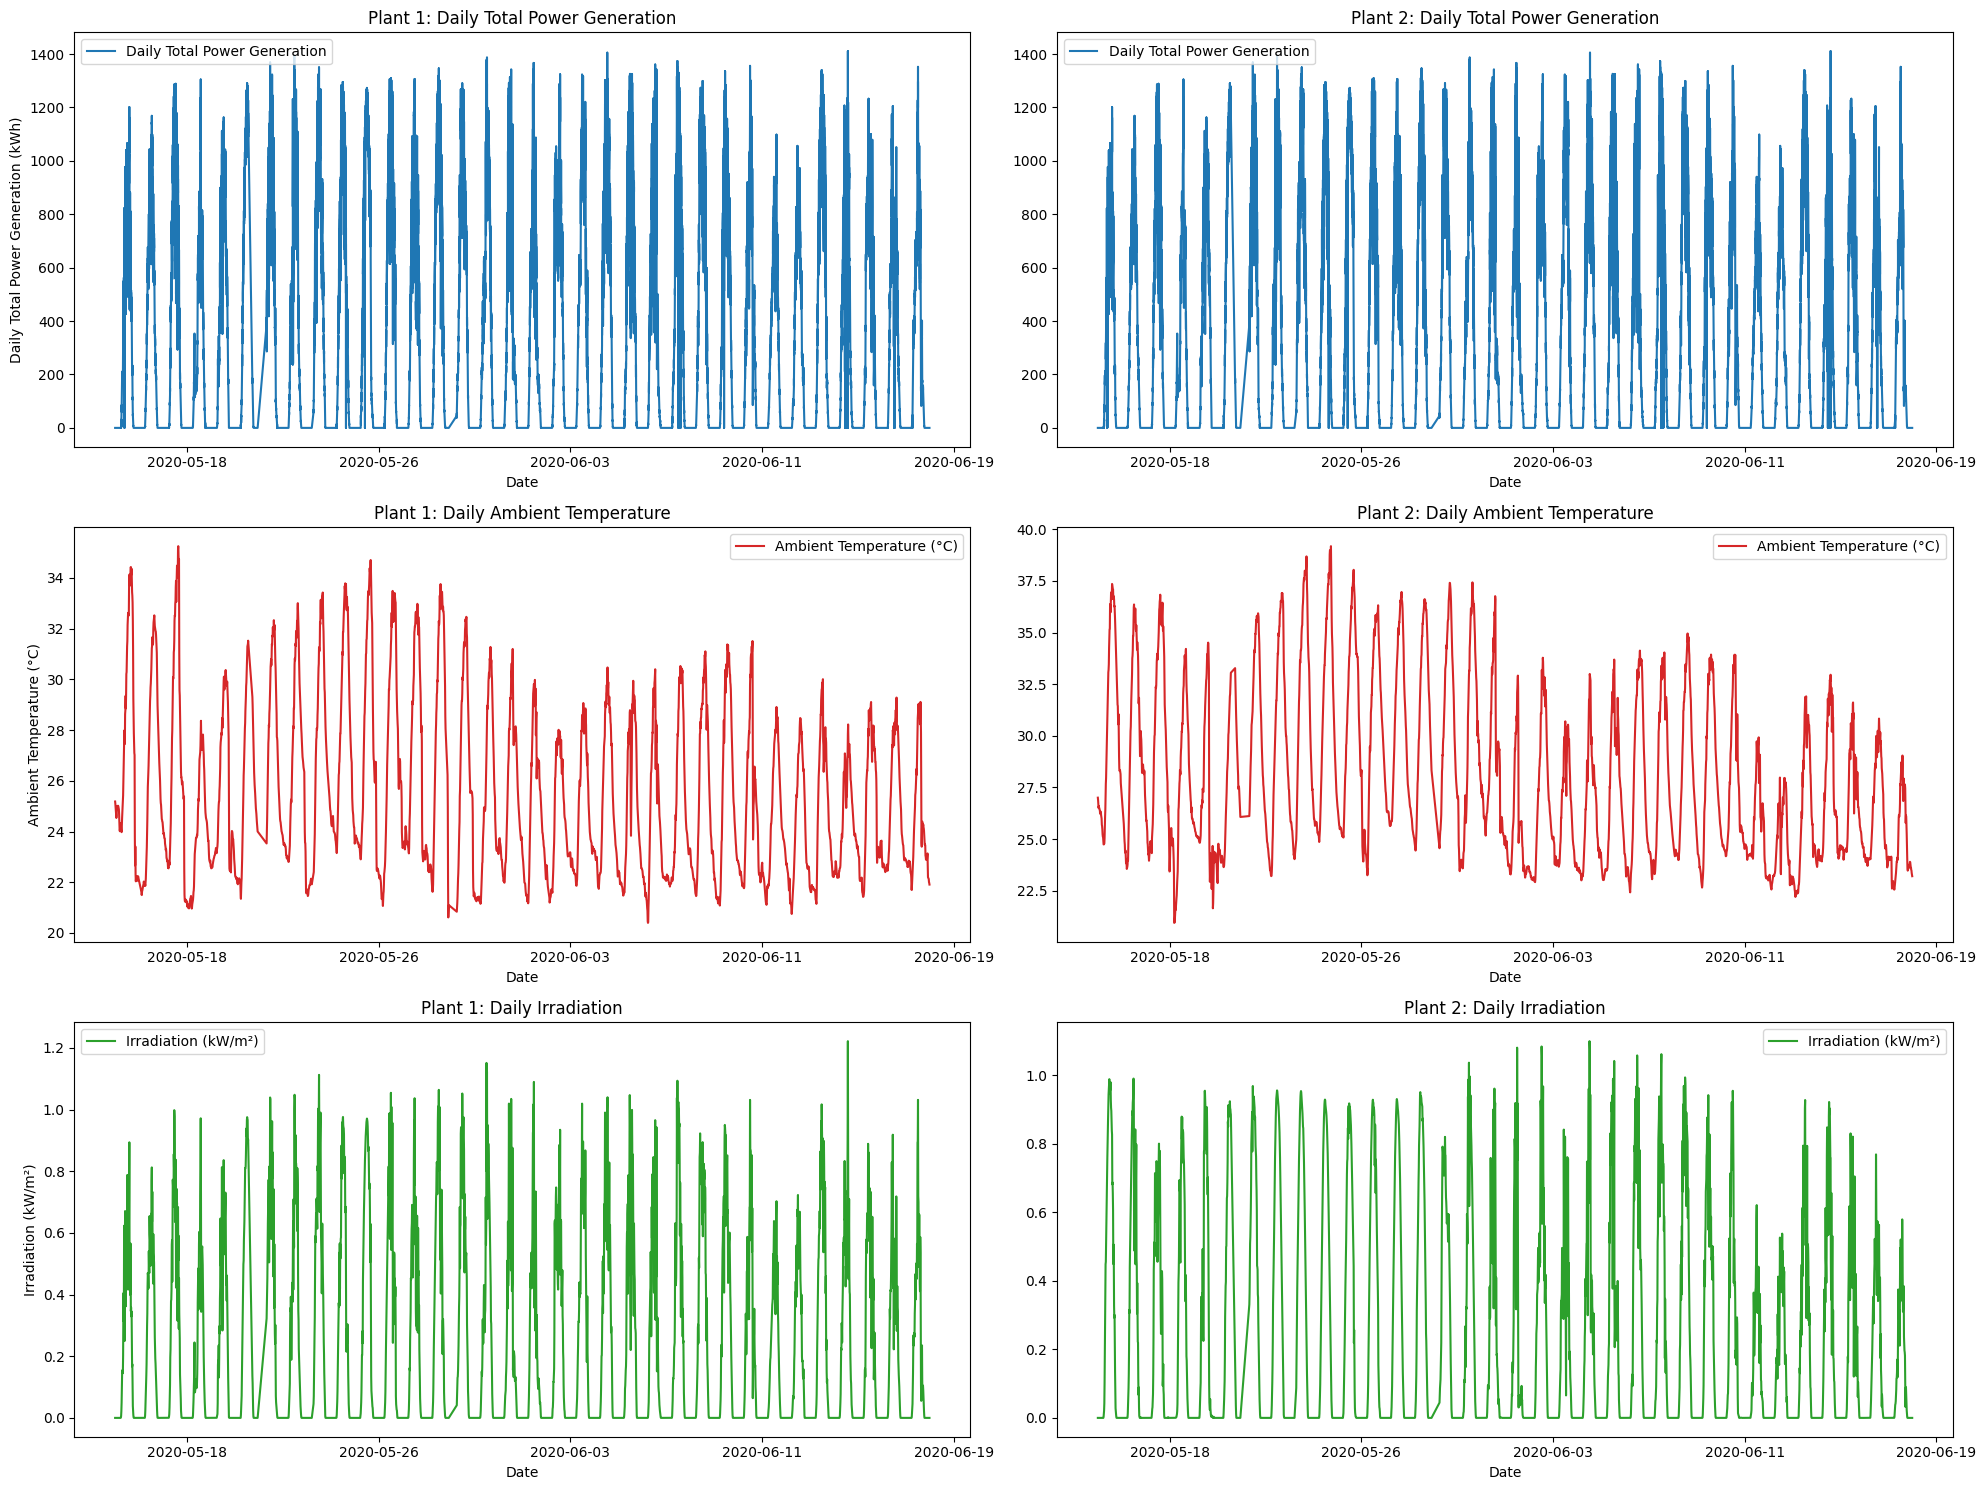

In [30]:
# Adjusting the layout to display Plant 1 and Plant 2 side by side for comparison

# Setting up the plot area for side-by-side comparison
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Plant 1 Daily Total Power Generation
axs[0, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["AC_POWER"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 0].set_title("Plant 1: Daily Total Power Generation")
axs[0, 0].set_ylabel("Daily Total Power Generation (kWh)")
axs[0, 0].legend()

# Plant 2 Daily Total Power Generation
axs[0, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["AC_POWER"],
    color="tab:blue",
    label="Daily Total Power Generation",
)
axs[0, 1].set_title("Plant 2: Daily Total Power Generation")
axs[0, 1].legend()

# Plant 1 Ambient Temperature
axs[1, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 0].set_title("Plant 1: Daily Ambient Temperature")
axs[1, 0].set_ylabel("Ambient Temperature (°C)")
axs[1, 0].legend()

# Plant 2 Ambient Temperature
axs[1, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["AMBIENT_TEMPERATURE"],
    color="tab:red",
    label="Ambient Temperature (°C)",
)
axs[1, 1].set_title("Plant 2: Daily Ambient Temperature")
axs[1, 1].legend()

# Plant 1 Irradiation
axs[2, 0].plot(
    plant_1_data["DATE_TIME"],
    plant_1_data["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 0].set_title("Plant 1: Daily Irradiation")
axs[2, 0].set_ylabel("Irradiation (kW/m²)")
axs[2, 0].legend()

# Plant 2 Irradiation
axs[2, 1].plot(
    plant_2_data["DATE_TIME"],
    plant_2_data["IRRADIATION"],
    color="tab:green",
    label="Irradiation (kW/m²)",
)
axs[2, 1].set_title("Plant 2: Daily Irradiation")
axs[2, 1].legend()

# Setting up the x-axis labels
for ax in axs.flat:
    ax.set_xlabel("Date")
    ax.xaxis.set_major_locator(
        plt.MaxNLocator(6)
    )  # Limit the number of x-axis labels to make them readable

plt.tight_layout()
plt.show()

### Correlation Matrix


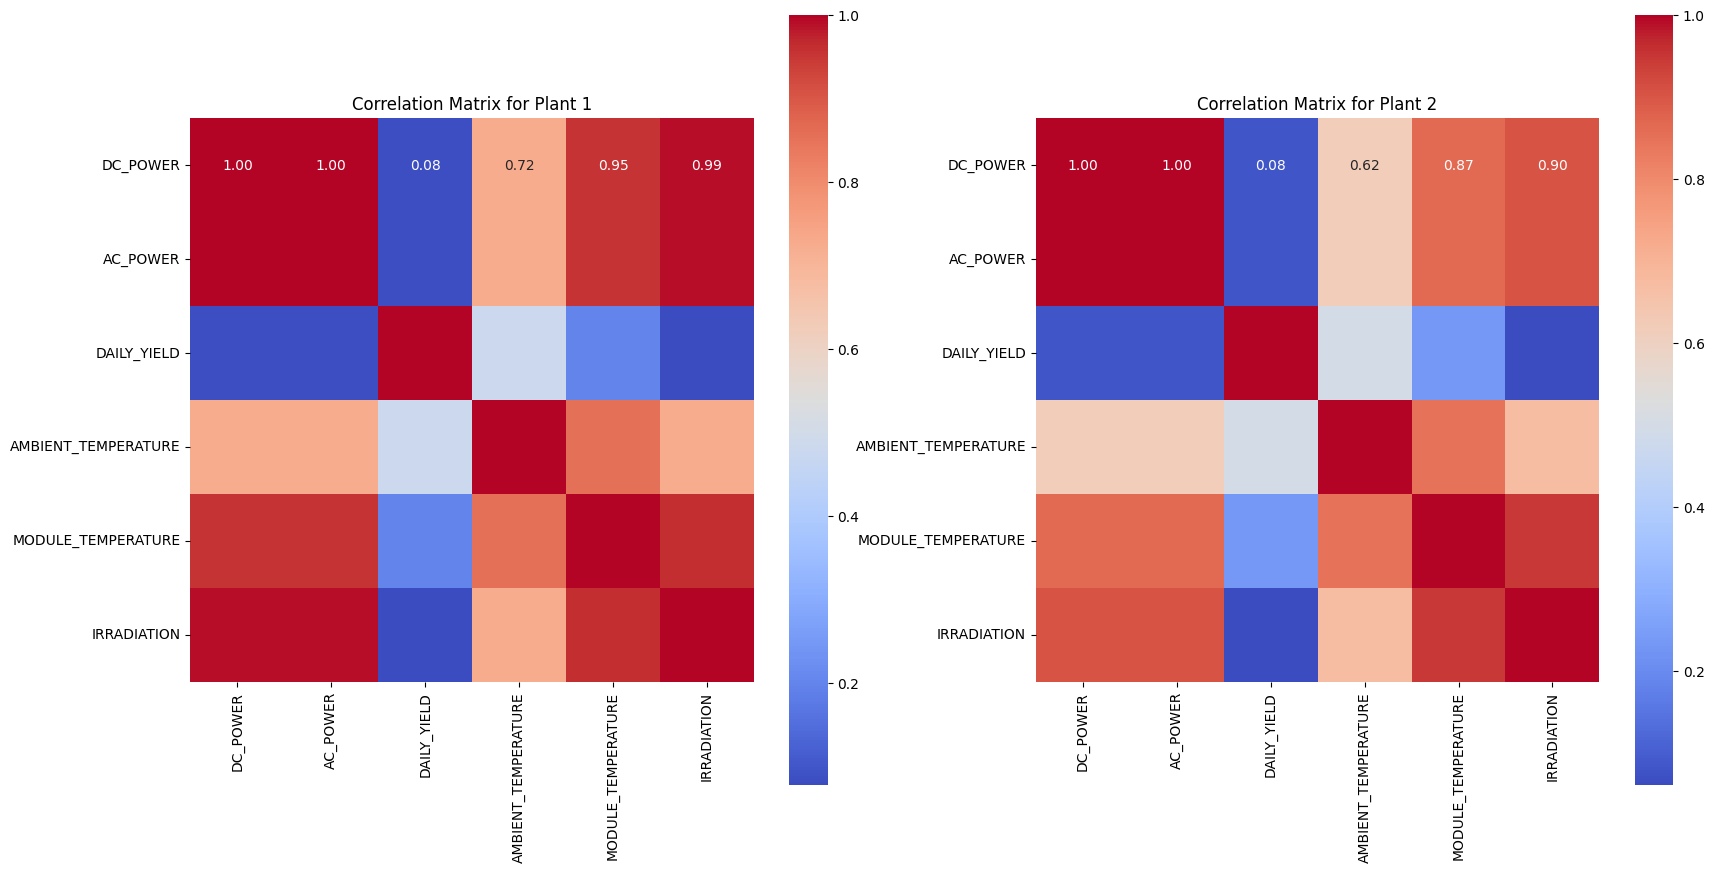

In [31]:
relevant_columns = [
    "DC_POWER",
    "AC_POWER",
    "DAILY_YIELD",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "IRRADIATION",
]

correlation_matrix_1 = plant_1_data[relevant_columns].corr()
correlation_matrix_2 = plant_2_data[relevant_columns].corr()


plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_1, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix for Plant 1")

plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_2, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix for Plant 2")

plt.show()

## Prediction


### Preparation


In [32]:
# Preparing features and target variable
features = data_combined[["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
target = data_combined["AC_POWER"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(96237, 3) (96237,)
(41245, 3) (41245,)


In [33]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SVM


In [34]:
# # SVM Model Training
# svm_model = SVR(kernel="rbf")
# svm_model.fit(X_train_scaled, y_train)

# # Predictions and Performance Evaluation
# y_pred_svm = svm_model.predict(X_test_scaled)

# # Calculating R^2 and MSE for the models
# svm_score = svm_model.score(X_test_scaled, y_test) * 100
# svm_r2 = r2_score(y_test, y_pred_svm) * 100
# mse_svm = mean_squared_error(y_test, y_pred_svm)

# print(f"SVM Model score = {svm_score:4.4f}%")
# print(f"SVM Model R^2 = {svm_r2:4.4f}")
# print(f"SVM Model MSE = {mse_svm:4.4f}")

### GBDT


In [35]:
# GBDT Model Training
gbdt_model = GradientBoostingRegressor()
gbdt_model.fit(X_train_scaled, y_train)

# Predictions and Performance Evaluation
y_pred_gbdt = gbdt_model.predict(X_test_scaled)

# Calculating R^2 and MSE for the models
gbdt_score = gbdt_model.score(X_test_scaled, y_test) * 100
gbdt_r2_score = r2_score(y_test, y_pred_gbdt) * 100
mse_gbdt = mean_squared_error(y_test, y_pred_gbdt)

print(f"GBDT Model score = {gbdt_score:4.4f}%")
print(f"GBDT Model R^2 score = {gbdt_r2_score:4.4f}")
print(f"GBDT Model MSE = {mse_gbdt:4.4f}")

GBDT Model score = 92.0792%
GBDT Model R^2 score = 92.0792
GBDT Model MSE = 12243.8884


### NNet


#### Data Transform


In [36]:
X_train_torch = torch.tensor(X_train_scaled.astype(np.float32))
y_train_torch = torch.tensor(y_train.values.astype(np.float32))
X_test_torch = torch.tensor(X_test_scaled.astype(np.float32))
y_test_torch = torch.tensor(y_test.values.astype(np.float32))


train_data = TensorDataset(X_train_torch, y_train_torch)
test_data = TensorDataset(X_test_torch, y_test_torch)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#### Model


In [37]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


model = NNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

nnet_r2 = r2_score(targets, predictions) * 100
print(f"NNet R^2 Score: {nnet_r2}")

In [38]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.hidden2out(lstm_out.view(len(input), -1))
        output = self.softmax(output)
        return output


model = LSTM(3, 32, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# Model Evaluation
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predictions.extend(output.view(-1).tolist())
        targets.extend(target.tolist())

lstm_r2 = r2_score(targets, predictions) * 100
print(f"LSTM R^2 Score: {lstm_r2}")

Epoch 1, Loss: 292500.9375
Epoch 2, Loss: 327098.125
Epoch 3, Loss: 244642.4375
Epoch 4, Loss: 256200.953125
Epoch 5, Loss: 296272.21875
Epoch 6, Loss: 171628.25
Epoch 7, Loss: 142929.515625
Epoch 8, Loss: 166407.796875
Epoch 9, Loss: 196314.421875
Epoch 10, Loss: 382313.78125
LSTM R^2 Score: -60.61673468008222
